### TTree and RNTuple loading comparison while using uproot

RNTuple is a developed I/O subsystem available in ROOT as experimental feature. It supposed to fully change TTree. (https://indico.fnal.gov/event/23628/contributions/240607/attachments/154861/201536/rntuple-rootws22.pdf) <br> 
After RNTuple files are created with ROOT, we need to make sure that uproot is able to load data from them with no issues. <br>
Additionally, checks must be done to compare TTree and RNTuple performance - it is expected that RNTuple should more efficient in the context of time and memory.<br>

This notebook demonstrates:
- Various time comparison tests for TTree and RNTuple on uproot abstraction level;
- Some data integrity tests for RNTuple


In [1]:
import awkward as ak
import numpy as np
import uproot
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


print(f"awkward: {ak.__version__}")
print(f"uproot: {uproot.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.7
uproot: 5.3.13.dev30+g0a84fd8


### File loading
Load ROOT files with one of two approaches: uproot or coffea.<br>
NOTE: coffea uses Dask, which does not support RNTuple yet. Therefore, in this notebook we will only use data loaded with uproot.

In [2]:
all_files = {}
events_dict = {}

## Remote files:
# all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/rntuple/nanoAOD/TT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # RNTuple remote
# all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # TTree remote

# Files downloaded locally:
all_files["TT"] = "/home/cms-jovyan/my_root_files/ttree/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root" # TTree local
all_files["RN"] = "/home/cms-jovyan/my_root_files/rntuple/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root"  # RNTuple local


# RNTuple files created with different ROOT versions:
# all_files["632"] = "/home/cms-jovyan/my_root_files/rntuple_v6_632_0909.root" # RNTuple, ROOT_632 (works)
# all_files["6x"] = "/home/cms-jovyan/my_root_files/rntuple_v7_6_0909.root" # RNTuple, ROOT_6_X (does not work)


def load_files_with_uproot(files):
    for key, file in files.items():
        with uproot.open(file) as f:
            events = f["Events"]
            events_dict[key] = events
            print("File was loaded with uproot, event count: ", len(events.keys()))
            
        
def load_files_with_coffea(files):
    for key, file in files.items():
        events = NanoEventsFactory.from_root({file: "Events"}, schemaclass=NanoAODSchema).events()
        events_dict[key] = events
        print("File was loaded with coffea, fields count: ", len(events.fields))
        
load_files_with_uproot(all_files)

# load_files_with_coffea(all_files)




File was loaded with uproot, event count:  947
File was loaded with uproot, event count:  947


### timeit tests
Measure time for different operations related to data loading. Compare durations between TTree and RNTuple operations.<br>

In [3]:
import timeit
    
def format_test_results(times):
    df = pd.DataFrame(times )
    
    col_count = len(df.columns)
    
    # Set custom column names based on col count (quick solution):
    if col_count == 4:
        df.columns =['key_cnt', 'data_type', 'func_name', 'time(s)']
        # Convert key_cnt to int if it's not already
        df['key_cnt'] = df['key_cnt'].astype(int)
        df = df.sort_values(by=['key_cnt'])
        df['func_name'] = df['func_name'].str.replace('_', ' ', regex=False)
        df['time(s)'] = df['time(s)'].round(4)
        df_pivot = df.pivot_table(index='key_cnt', columns='data_type', values='time(s)')

    elif col_count == 3:
        df.columns = ['data_type', 'func_name', 'time(s)']
        df['time(s)'] = df['time(s)'].round(4)
        df_pivot = df.pivot_table(index='func_name', columns='data_type', values='time(s)')
    # Clean up the columns and reset index if needed
    df_pivot.columns.name = None  # Remove the name of the columns
    df_pivot = df_pivot.reset_index()  # Reset the index if you want a cleaner look
    
    return df_pivot


def load_file(data_type, file):
    with uproot.open(file) as f:
        events = f["Events"]
        events_dict[data_type] = events

def load_arrays_for_each_key(events):
    for key in events.keys():
        events.arrays(filter_name=[key])[key]
        
def load_all_arrays(events):
    events.arrays()
    
def load_all_arrays_while_using_filter_name(events):
    chosen_keys = events.keys()
    events.arrays(filter_name=chosen_keys)[chosen_keys]

def load_array_while_using_filter_name(events):
    key = "GenPart_pt"
    events.arrays(filter_name=[key])[key]
    
    
def load_24_arrays_while_using_filter_name(events, keys):
    events.arrays(filter_name=keys)[keys]
        
def start_all_performance_tests():
    print("Starting to timeit on various functions: ")
    times = []
    # events_dict = {}

    
    chosen_keys = [
        "GenPart_pt", "GenPart_eta", "GenPart_phi", "CorrT1METJet_phi",
        "GenJet_pt", "CorrT1METJet_eta", "SoftActivityJet_pt",
        "Jet_eta", "Jet_phi", "SoftActivityJet_eta", "SoftActivityJet_phi", 
        "CorrT1METJet_rawPt", "Jet_btagDeepFlavB", "GenJet_eta", 
        "GenPart_mass", "GenJet_phi",
        "Jet_puIdDisc", "CorrT1METJet_muonSubtrFactor", "Jet_btagDeepFlavCvL",
        "Jet_btagDeepFlavQG", "Jet_mass", "Jet_pt", "GenPart_pdgId",
        "Jet_btagDeepFlavCvB", "Jet_cRegCorr"
        ]
    
    
    
    for data_type, file in all_files.items():
        time_taken = timeit.timeit(lambda: load_file(data_type, file), number=1)
        times.append((data_type, "load_file", time_taken))

        time_taken = timeit.timeit(lambda: load_arrays_for_each_key(events_dict[data_type]), number=1)
        times.append((data_type, "load_arrays_for_each_key", time_taken))
        
        time_taken = timeit.timeit(lambda: load_all_arrays(events_dict[data_type]), number=1)
        times.append((data_type, "load_all_arrays", time_taken))
        
        time_taken = timeit.timeit(lambda: load_all_arrays_while_using_filter_name(events_dict[data_type]), number=1)
        times.append((data_type, "load_all_arrays_while_using_filter_name", time_taken))
        
        time_taken = timeit.timeit(lambda: load_24_arrays_while_using_filter_name(events_dict[data_type], chosen_keys), number=1)
        times.append((data_type, "load_24_arrays_while_using_filter_name", time_taken))
        
        time_taken = timeit.timeit(lambda: load_array_while_using_filter_name(events_dict[data_type]), number=1)
        times.append((data_type, "load_array_while_using_filter_name", time_taken))
        
    return format_test_results(times)


def measure_increasing_key_count():
    print("Starting to timeit loading arrays with increasing count: ")
    times = []
    all_keys = events_dict["TT"].keys()
    print("Count of keys: ", len(all_keys))
    
    for data_type, file in all_files.items():
        for i in range(0, len(all_keys), 50):
            time_taken = timeit.timeit(lambda: load_24_arrays_while_using_filter_name(events_dict[data_type], all_keys[:i]), number=1)
            times.append((i, data_type, f"load_{i}_arrays_while_using_filter_name", time_taken))
            # print(data_type, i, time_taken)
        # print(data_type, "tests finished")
    return format_test_results(times)

def measure_array_loading_with_different_arrays():
    # NOTE: two arrays always loaded instead of one, to have a workaround for the issue when RNTuple is much slower when loading only one array:
    print("Starting to timeit loading arrays with increasing count: ")
    times = []
    all_keys = events_dict["TT"].keys()
    print("Count of keys: ", len(all_keys))
    
    for data_type, file in all_files.items():
        for i in range(0, len(all_keys), 1):
            time_taken = timeit.timeit(lambda: load_24_arrays_while_using_filter_name(events_dict[data_type], all_keys[i]), number=1)
            times.append((i, data_type, f"load_{i}_arrays_while_using_filter_name", time_taken))
            # print(data_type, i, time_taken)
        # print(data_type, "tests finished")
    return format_test_results(times)


results_1 = start_all_performance_tests()
results_2 = measure_increasing_key_count()
results_3 = measure_array_loading_with_different_arrays()

# Calculate the sum for each column (excluding 'func_name')
sums = results_1[['RN', 'TT']].sum()
results_1.loc['Total'] = pd.Series(sums, name='Total')

print("timeit results (in seconds): \n", results_1.to_markdown(index=True))




Starting to timeit on various functions: 
Starting to timeit loading arrays with increasing count: 
Count of keys:  947
Starting to timeit loading arrays with increasing count: 
Count of keys:  947
timeit results (in seconds): 
 |       | func_name                               |      RN |       TT |
|:------|:----------------------------------------|--------:|---------:|
| 0     | load_24_arrays_while_using_filter_name  |  0.905  |   1.7425 |
| 1     | load_all_arrays                         |  4.6779 |  49.2358 |
| 2     | load_all_arrays_while_using_filter_name |  4.5086 |  56.5101 |
| 3     | load_array_while_using_filter_name      |  0.1562 |   0.246  |
| 4     | load_arrays_for_each_key                | 55.001  |  20.3523 |
| 5     | load_file                               |  0.0008 |   0.305  |
| Total | nan                                     | 65.2495 | 128.392  |


### Execution time graphs:
- Graph 1: with each iteration more arrays are loaded at the same time. At first iteration 50 arrays are loaded, and 900 in the last.
- Graph 2: each single array in the file is loaded separately and execution time is measured. This way we can see how much time each array takes to load.

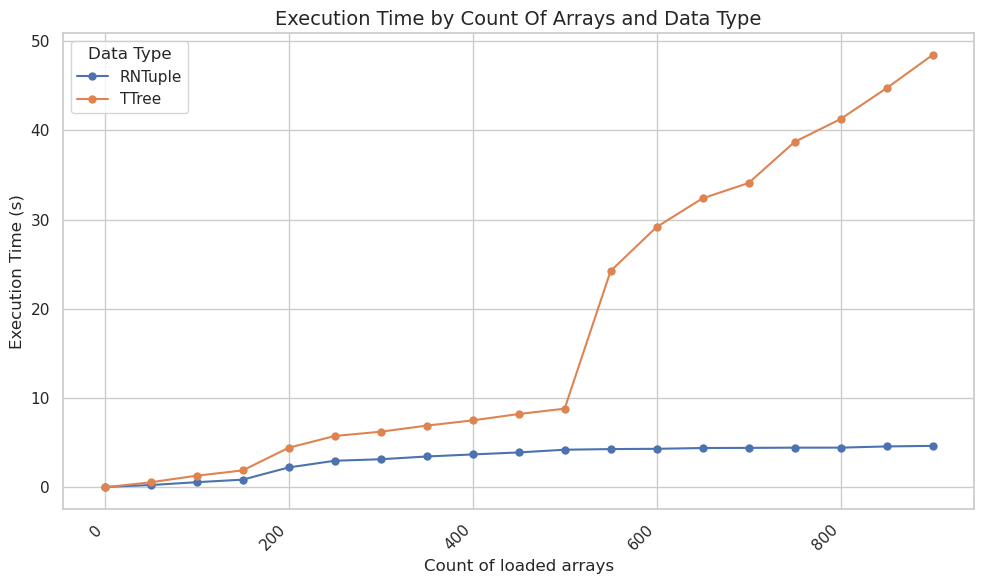

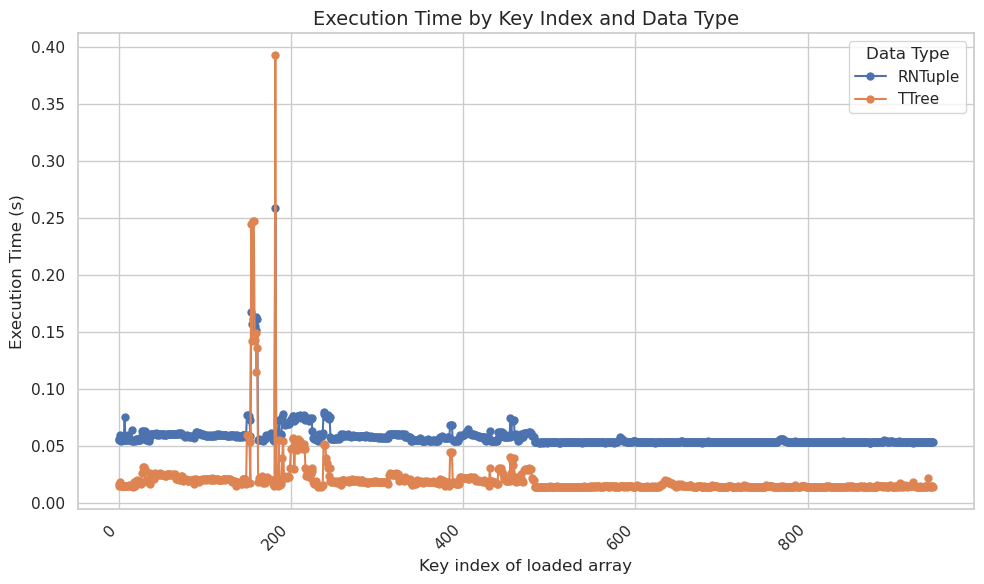

In [4]:
def plot_results(df, title, xlabel):
    # Set plot style
    sns.set(style="whitegrid")

    # Melt the DataFrame to a long format for seaborn
    df_melted = df.melt(id_vars=['key_cnt'], var_name='Data Type', value_name='Time (s)')
    
    # Create a line plot
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='key_cnt', y='Time (s)', hue='Data Type', marker='o', markeredgewidth=0, data=df_melted)
    
    # Add labels and title
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel('Execution Time (s)', fontsize=12)
    plt.title(title, fontsize=14)
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')
    
    # Show plot
    plt.tight_layout()
    plt.show()


# print(results_2)
results_2.rename(columns={'RN': 'RNTuple', 'TT': 'TTree'}, inplace=True)

results_3.rename(columns={'RN': 'RNTuple', 'TT': 'TTree'}, inplace=True)

plot_results(df=results_2, title='Execution Time by Count Of Arrays and Data Type', xlabel='Count of loaded arrays')
# NOTE: To prove that accumulation of execution time is negligible, 
plot_results(df=results_3, title='Execution Time by Key Index and Data Type', xlabel='Key index of loaded array')




# results_1.to_csv('results_1.csv', index=True)
# results_2.to_csv('results_2.csv', index=True)

### Check RNTuple data integrity
When loading RNTuple data we need to be sure that data is correct. We do that by comparing RNTuple array data with TTree - it should be identical. <br>
Comparison should be done with all arrays, but for demonstration purposes and time saving we use specific columns from https://github.com/iris-hep/idap-200gbps/blob/main/materialize_branches.ipynb notebook.

In [5]:
# This cell compares data between TTree and RNTuple for each key array, ensuring that RNTuple does not have corrupted data:
def compare_all_arrays(events_1, events_2, keys):
    ak_match_count = 0
    ak_mismatch_count = 0
    ak_error_count = 0
        
    for key in keys:
        arrays_1 = events_1.arrays([key])[key]
        arrays_2 = events_2.arrays([key])[key]

        # Check if arrays are equal:
        try:                
            # Custom function to compare NaN-aware equality
            def nan_equal(x, y):
                if isinstance(x, (list, ak.Array)) and isinstance(y, (list, ak.Array)):
                    return all(nan_equal(a, b) for a, b in zip(x, y))
                return (x == y) or (np.isnan(x) and np.isnan(y))
            # Check if the lengths of the outermost arrays are equal
            assert len(arrays_1) == len(arrays_2)

            # Compare the arrays using the custom function
            are_equal = nan_equal(arrays_1.tolist(), arrays_2.tolist())

            if are_equal:
                ak_match_count += 1
                print(f"[{key}]", "ak arrays are equal")
            elif not are_equal:
                ak_mismatch_count += 1
                print(f"[{key}]", "ak comparison MISMATCH")
                print("tt: ", arrays_1, f"Type: {ak.type(arrays_1)}.")
                print("rn: ", arrays_2, f"Type: {ak.type(arrays_2)}.")

        except:
            ak_error_count += 1
            print(f"[{key}]", "ak comparison ERROR")
            print("tt: ", arrays_1, f"Type: {ak.type(arrays_1)}")
            print("rn: ", arrays_2, f"Type: {ak.type(arrays_2)}")

    print(f"ak array comparison statistics: matched count: {ak_match_count}; mismatch count: {ak_mismatch_count}; errors: {ak_error_count}")
    
events_tt = events_dict["TT"]
events_rn = events_dict["RN"]

keys = [
        "GenPart_pt", "GenPart_eta", "GenPart_phi", "CorrT1METJet_phi",
        "GenJet_pt", "CorrT1METJet_eta", "SoftActivityJet_pt",
        "Jet_eta", "Jet_phi", "SoftActivityJet_eta", "SoftActivityJet_phi", 
        "CorrT1METJet_rawPt", "Jet_btagDeepFlavB", "GenJet_eta", 
        "GenPart_mass", "GenJet_phi",
        "Jet_puIdDisc", "CorrT1METJet_muonSubtrFactor", "Jet_btagDeepFlavCvL",
        "Jet_btagDeepFlavQG", "Jet_mass", "Jet_pt", "GenPart_pdgId",
        "Jet_btagDeepFlavCvB", "Jet_cRegCorr"
        ]

compare_all_arrays(events_tt, events_rn, keys)

    


[GenPart_pt] ak arrays are equal
[GenPart_eta] ak arrays are equal
[GenPart_phi] ak arrays are equal
[CorrT1METJet_phi] ak arrays are equal
[GenJet_pt] ak arrays are equal
[CorrT1METJet_eta] ak arrays are equal
[SoftActivityJet_pt] ak arrays are equal
[Jet_eta] ak arrays are equal
[Jet_phi] ak arrays are equal
[SoftActivityJet_eta] ak arrays are equal
[SoftActivityJet_phi] ak arrays are equal
[CorrT1METJet_rawPt] ak arrays are equal
[Jet_btagDeepFlavB] ak arrays are equal
[GenJet_eta] ak arrays are equal
[GenPart_mass] ak arrays are equal
[GenJet_phi] ak arrays are equal
[Jet_puIdDisc] ak arrays are equal
[CorrT1METJet_muonSubtrFactor] ak arrays are equal
[Jet_btagDeepFlavCvL] ak arrays are equal
[Jet_btagDeepFlavQG] ak arrays are equal
[Jet_mass] ak arrays are equal
[Jet_pt] ak arrays are equal
[GenPart_pdgId] ak arrays are equal
[Jet_btagDeepFlavCvB] ak arrays are equal
[Jet_cRegCorr] ak arrays are equal
ak array comparison statistics: matched count: 25; mismatch count: 0; errors: 0


### Test RNTuple data loading from cluster edges
There was an issue detected, where RNTuple array data integrity was lost each time when index range crossed edge boundaries. (PR: https://github.com/scikit-hep/uproot5/pull/1285) This cell checks small set of data around clustary edges.

In [6]:
# Comparing only certain regions of arrays:
def compare_array_region(key, events_tt, events_rn, strt, end):
    arr_tt = events_tt.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
    arr_rn = events_rn.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]

    try:
        # Custom function to compare NaN-aware equality
        def nan_equal(x, y):
            if isinstance(x, (list, ak.Array)) and isinstance(y, (list, ak.Array)):
                return all(nan_equal(a, b) for a, b in zip(x, y))
            return (x == y) or (np.isnan(x) and np.isnan(y))
        # Check if the lengths of the outermost arrays are equal
        assert len(arr_tt) == len(arr_rn)
        # Compare the arrays using the custom function
        comparison_result = nan_equal(arr_tt.tolist(), arr_rn.tolist())
        # Final assertion
        assert comparison_result
        return True
    except Exception as e:
        print(f"TT array: {arr_tt}")
        print(f"RN array: {arr_rn}")
        print(f"Failure limits: {(strt, end)}")
        print("")
        return False

# Collect all regions near cluster edges, where data does not match:
def collect_breaking_points(key):
    cluster_starts = [md.num_first_entry for md in events_rn.cluster_summaries][1:] # Skip first, because it is 0.
    print("Starts of clusters: ", cluster_starts)

    step = 4
    for cl_start in cluster_starts:
        for i in range (cl_start-9, cl_start+9, step):
            strt = i
            end = i + step
            result = compare_array_region(key, events_tt, events_rn, strt, end)
            print(f"Range: ({strt},{end}). Match result: {result}")

key = "Electron_hoe"
collect_breaking_points(key)
print("Finished cell.")

Starts of clusters:  [17224, 51094, 85025, 118948, 152870, 186775]
Range: (17215,17219). Match result: True
Range: (17219,17223). Match result: True
Range: (17223,17227). Match result: True
Range: (17227,17231). Match result: True
Range: (17231,17235). Match result: True
Range: (51085,51089). Match result: True
Range: (51089,51093). Match result: True
Range: (51093,51097). Match result: True
Range: (51097,51101). Match result: True
Range: (51101,51105). Match result: True
Range: (85016,85020). Match result: True
Range: (85020,85024). Match result: True
Range: (85024,85028). Match result: True
Range: (85028,85032). Match result: True
Range: (85032,85036). Match result: True
Range: (118939,118943). Match result: True
Range: (118943,118947). Match result: True
Range: (118947,118951). Match result: True
Range: (118951,118955). Match result: True
Range: (118955,118959). Match result: True
Range: (152861,152865). Match result: True
Range: (152865,152869). Match result: True
Range: (152869,15